In [1]:
suppressPackageStartupMessages({
options(stringsAsFactors = FALSE)
library(Matrix)
library(Seurat)
library(ggplot2)
library(dplyr)
library(stringr)
library(readr)
        })

In [2]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] readr_2.1.5        stringr_1.5.1      dplyr_1.1.4        ggplot2_3.5.1     
[5] SeuratObject_4.1.4 Seurat_4.4.0       Matrix_1.6-5      

loaded via a namespace (and not attached):
  [1] deldir_2.0-2           pbapply_1.7-2          gridExtra_2.3         
  [4] rlang_1.1.4            magrittr_2.0.3         RcppAnnoy_0.0.22      
  [7] spatstat.geom_3.2-9    matrixStats_1.3.0      ggridges_0.5.6        

In [3]:
set.seed(2021)
df_biomart <- read.table("./mart_export_human_mouse.txt", header=T)
df_biomart$link = paste0(df_biomart$Mouse_ID,"-",df_biomart$Human_ID)

In [6]:
###########Pijuan ##########
pijuan_mtx_link <- readRDS('./pseudobulk_matrices/pijuan_mtx_noExE_liftover.RDS')
pijuan_cell <- data.frame(embryo=colnames(pijuan_mtx_link),day=str_split_fixed(colnames(pijuan_mtx_link),'_',2)[,1],
                          dataset='pijuan',somite_number=NA)
row.names(pijuan_cell) <- pijuan_cell$embryo
#subset to E7-8.5
pijuan_cell_7_8 <- pijuan_cell[pijuan_cell$day %in% c('E7','E7.25','E7.5','E7.75','E8','E8.25','E8.5'),]
pijuan_mtx_link <- pijuan_mtx_link[,row.names(pijuan_cell_7_8)]

###########MOCA ##########
MOCA_mtx_link <- readRDS('./pseudobulk_matrices/MOCA_mtx_noExE_liftover.RDS')
#MOCA_mtx_meta <- readRDS('~/nobackups/MOCA_mtx_meta.RDS')
embryo_info <- readRDS('./MOCA_E85_embryo_info.rds')
embryo_info$embryo = gsub('E8.5_','E8.5b_',embryo_info$RT_group)
MOCA_cell <- data.frame(embryo=colnames(MOCA_mtx_link),day=str_split_fixed(colnames(MOCA_mtx_link),'_',2)[,1])
MOCA_cell$dataset='MOCA'
MOCA_cell <- left_join(MOCA_cell, embryo_info,by=c('embryo' = 'RT_group'))%>%select(c('embryo','day','dataset','somite_number'))
row.names(MOCA_cell) <- MOCA_cell$embryo
MOCA_cell$day = ifelse(MOCA_cell$day=='E8.5','E8.5b',MOCA_cell$day)

##########human embryo(CS12-16) ##########
pb_mtx_hvg <- readRDS('./pseudobulk_matrices/human_embryo_cs12-16.RDS')
pb_cell <- data.frame(embryo=colnames(pb_mtx_hvg),
                     day=str_split_fixed(colnames(pb_mtx_hvg),'_',2)[,1],
                     dataset='HEOA',somite_number=NA)
row.names(pb_cell) <- pb_cell$embryo
pb_cell <- pb_cell %>% select(c('embryo','day')) %>%mutate(dataset='HEOA',somite_number=NA)

###########human embryo (CS7) ##########
pb_CS7_n <- readRDS('./pseudobulk_matrices/human_embryo_CS7_normalized.RDS')
cs7_cell <- data.frame(embryo='emb_cs7',day='CS7',dataset='human_embryo_cs7',somite_number=NA)
row.names(cs7_cell) <- cs7_cell$embryo

###########Gastruloids & somitoids
query_mtx_hG  <- readRDS('./pseudobulk_matrices/human_gastruloids_matrix.RDS')
query_cell_hG <- data.frame(embryo=colnames(query_mtx_hG),
                           day=gsub('_rna','',colnames(query_mtx_hG)),
                           dataset='gastruloids',
                          somite_number=NA)

# of shared orthologs: 770 
gene set: 455

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”


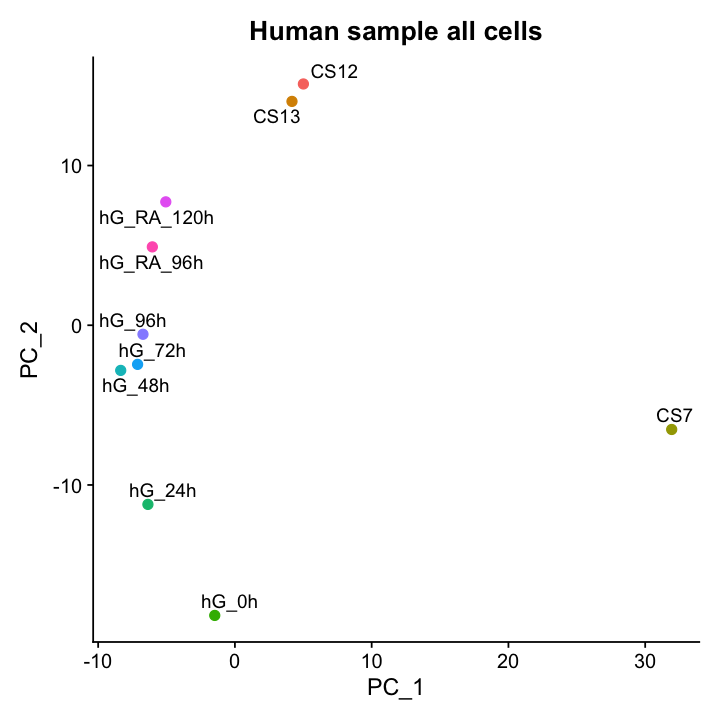

In [7]:
##########################################################################
#Building the PCA space by coembedding human embryos and gastruloids
##########################################################################
#Subset HEOA dataset to CS12/13
pb_mtx_hvg_sub <- pb_mtx_hvg[,1:2]
row.names(pb_mtx_hvg_sub) <- row.names(pb_mtx_hvg)
#Convert gene IDs of HEOA to match gene names of CS7
df_heoa <- df_biomart[df_biomart$Human_ID %in% row.names(pb_mtx_hvg_sub),]
pb_mtx_hvg_sub <- pb_mtx_hvg_sub[df_heoa$Human_ID,]
row.names(pb_mtx_hvg_sub) <- df_heoa$Human_name

#Combine heoa and CS7 matrix
homologs <- Reduce(intersect,list(names(pb_CS7_n),
                                  row.names(pb_mtx_hvg_sub),
                                 row.names(query_mtx_hG)))
cat('# of shared orthologs:', length(homologs),'\n')
heoa_cs7_hG_mtx <- Reduce(cbind,list(pb_mtx_hvg_sub[homologs,],
                                      pb_CS7_n[homologs],
                                      query_mtx_hG[homologs,]))
colnames(heoa_cs7_hG_mtx)[3]='emb_cs7'
heoa_cs7_hG_cell <- Reduce(rbind,list(pb_cell[1:2,],
                                       cs7_cell,
                                       query_cell_hG))
row.names(heoa_cs7_hG_cell) <- heoa_cs7_hG_cell$embryo

#Gene sets
obj_heoa_cs7_hG <- readRDS('./PCA_geneset.RDS')
gene_set <- row.names(obj_heoa_cs7_hG)
cat('gene set:',gene_set%>%length)
df_tmp <- df_biomart[df_biomart$link %in% gene_set,]
gene_set_human<- df_tmp$Human_name
heoa_cs7_hG_mtx_subset <- heoa_cs7_hG_mtx[c(gene_set_human%>%unique),]


#Co-embed
obj_heoa_cs7_hG <- CreateSeuratObject(counts=heoa_cs7_hG_mtx_subset,meta.data=heoa_cs7_hG_cell)
obj_heoa_cs7_hG  <- NormalizeData(obj_heoa_cs7_hG ,verbose=F)
VariableFeatures(obj_heoa_cs7_hG)  <- row.names(obj_heoa_cs7_hG)
obj_heoa_cs7_hG <- ScaleData(obj_heoa_cs7_hG,verbose=F)
obj_heoa_cs7_hG  <- RunPCA(obj_heoa_cs7_hG,verbose=F,npcs=8)
options(repr.plot.width=6, repr.plot.height=6)
DimPlot(obj_heoa_cs7_hG,group.by='day',pt.size=2.5,label=T,repel=T,label.size=4)+NoLegend()+ggtitle('Human sample all cells')

In [8]:
###########primate
pb_primate_link <- readRDS('./pseudobulk_matrices/primate_matrix_liftover.RDS')
pb_primate_cell <- data.frame(row.names=colnames(pb_primate_link),embryo=colnames(pb_primate_link),
                              day=str_split_fixed(colnames(pb_primate_link),'-',2)[,1],dataset='primate',
                             somite_number=NA)
##########mouse gastruloids
query_mtx_mG_link <- readRDS('./pseudobulk_matrices/mouse_gastruloids_matrix_liftover.RDS')
query_cell_mG <- data.frame(embryo=colnames(query_mtx_mG_link),
                           day=gsub('_rna','',colnames(query_mtx_mG_link)),
                           dataset='gastruloids',
                          somite_number=NA)
row.names(query_cell_mG)=query_cell_mG$embryo


##########Human stembryos
query_mtx_hstembryo_link <- readRDS('./pseudobulk_matrices/human_stembryos_matrix_liftover.RDS')
query_cell_hstembryo <- data.frame(embryo=colnames(query_mtx_hstembryo_link),
                           day=gsub('_rna','',colnames(query_mtx_hstembryo_link)),
                           dataset='hstembryo',
                          somite_number=NA)
row.names(query_cell_hstembryo)=query_cell_hstembryo$embryo



#Griboud et al, Nature Biotech
pb_griboud = readRDS('./pseudobulk_matrices/human_TLS_matrix.RDS')
pb_griboud_cell = data.frame(row.names=colnames(pb_griboud),embryo=colnames(pb_griboud),
                              day=colnames(pb_griboud),dataset='griboud',
                             somite_number=NA)
df_hG <- df_biomart[df_biomart$Human_name %in% row.names(pb_griboud),]
pb_griboud_link <- pb_griboud[df_hG$Human_name,,drop=FALSE]
row.names(pb_griboud_link) <- df_hG$link

[1] 468  10

[1] 424  96

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


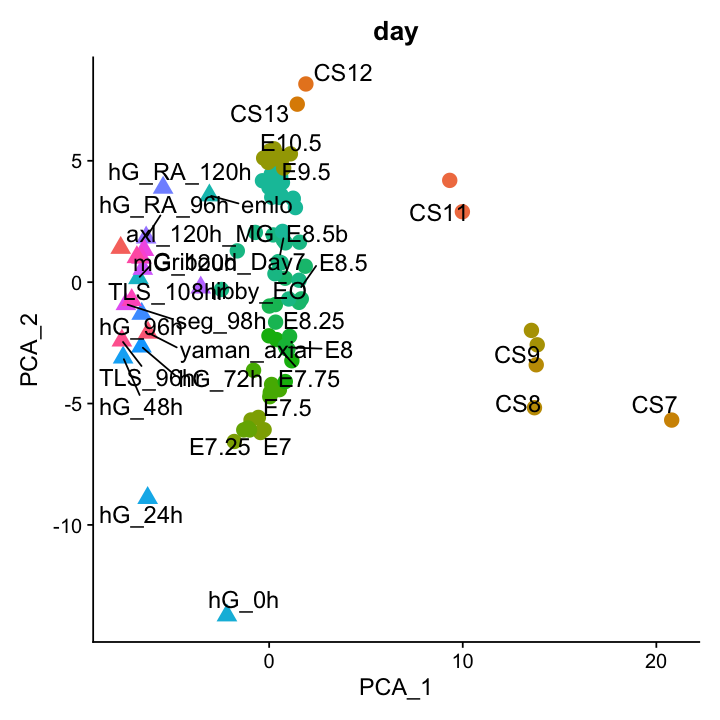

In [11]:
###########################
#Projection of query datasets onto PCA
###########################

#Liftover human PC
df_human <- df_biomart[df_biomart$Human_name %in% row.names(heoa_cs7_hG_mtx_subset),]
heoa_cs7_hG_mtx_link= heoa_cs7_hG_mtx_subset[as.vector(df_human$Human_name),]
rownames(heoa_cs7_hG_mtx_link) = df_human$link
dim(heoa_cs7_hG_mtx_link)

#PC2
irlba_heoa_cs7_hG <- Loadings(obj_heoa_cs7_hG,reduction='pca')
df_human <- df_biomart[df_biomart$Human_name %in% row.names(irlba_heoa_cs7_hG),]
irlba_heoa_cs7_hG_link= irlba_heoa_cs7_hG[as.vector(df_human$Human_name),]
rownames(irlba_heoa_cs7_hG_link) = df_human$link

#Combine query_mtx and reference datasets
homologs <- Reduce(intersect,list(row.names(heoa_cs7_hG_mtx_link),
                                  row.names(pb_primate_link),
                                  row.names(query_mtx_hstembryo_link),
                                  row.names(pb_griboud_link),
                                  row.names(query_mtx_mG_link),                                  
                                  row.names(pijuan_mtx_link),
                                  row.names(MOCA_mtx_link)
                                 ))
heoa_cs7_all_mtx <- Reduce(cbind,list(heoa_cs7_hG_mtx_link[homologs,],
                                      pb_primate_link[homologs,],
                                      query_mtx_hstembryo_link[homologs,],
                                      pb_griboud_link[homologs,,drop=FALSE],
                                      query_mtx_mG_link[homologs,],
                                      pijuan_mtx_link[homologs,],
                                      MOCA_mtx_link[homologs,]
                                ))
dim(heoa_cs7_all_mtx)
heoa_cs7_all_cell<- Reduce(rbind,list(heoa_cs7_hG_cell,
                                      pb_primate_cell,
                                      query_cell_hstembryo,
                                      pb_griboud_cell,
                                      query_cell_mG,
                                      pijuan_cell_7_8,
                                      MOCA_cell
                                      ))
row.names(heoa_cs7_all_cell) <- heoa_cs7_all_cell$embryo
obj_heoa_cs7_hG_all <- CreateSeuratObject(counts=heoa_cs7_all_mtx,meta.data=heoa_cs7_all_cell)
obj_heoa_cs7_hG_all <- NormalizeData(obj_heoa_cs7_hG_all ,verbose=F)
obj_heoa_cs7_hG_all <- ScaleData(obj_heoa_cs7_hG_all ,verbose=F)
homologs <- intersect(row.names(obj_heoa_cs7_hG_all$RNA@scale.data),row.names(irlba_heoa_cs7_hG_link))
VariableFeatures(obj_heoa_cs7_hG_all )=row.names(obj_heoa_cs7_hG_all )
heoa_cs7_hG_all_emb <- t(obj_heoa_cs7_hG_all$RNA@scale.data[homologs,]) %*% irlba_heoa_cs7_hG_link[homologs,]
obj_heoa_cs7_hG_all[['pca']] <- CreateDimReducObject(embeddings = heoa_cs7_hG_all_emb , key = "PCA_", assay = DefaultAssay(obj_heoa_cs7_hG_all))

options(repr.plot.width=6, repr.plot.height=6)
obj_heoa_cs7_hG_all$Source=ifelse(obj_heoa_cs7_hG_all$day %in% c('CS7',
                                                             'CS8','CS9','CS11',
                                                             'CS12','CS13',
                                             'E6.5','E6.75', 'E7','E7.25','E7.5','E7.75','E8','E8.25',
                                             'E8.5','E8.5b','E9.5','E10.5'), 'Embryo','Gastruloids')
DimPlot(obj_heoa_cs7_hG_all , group.by='day',shape.by = 'Source',pt.size=4,label=T,repel=T,label.size=5)+NoLegend()#+

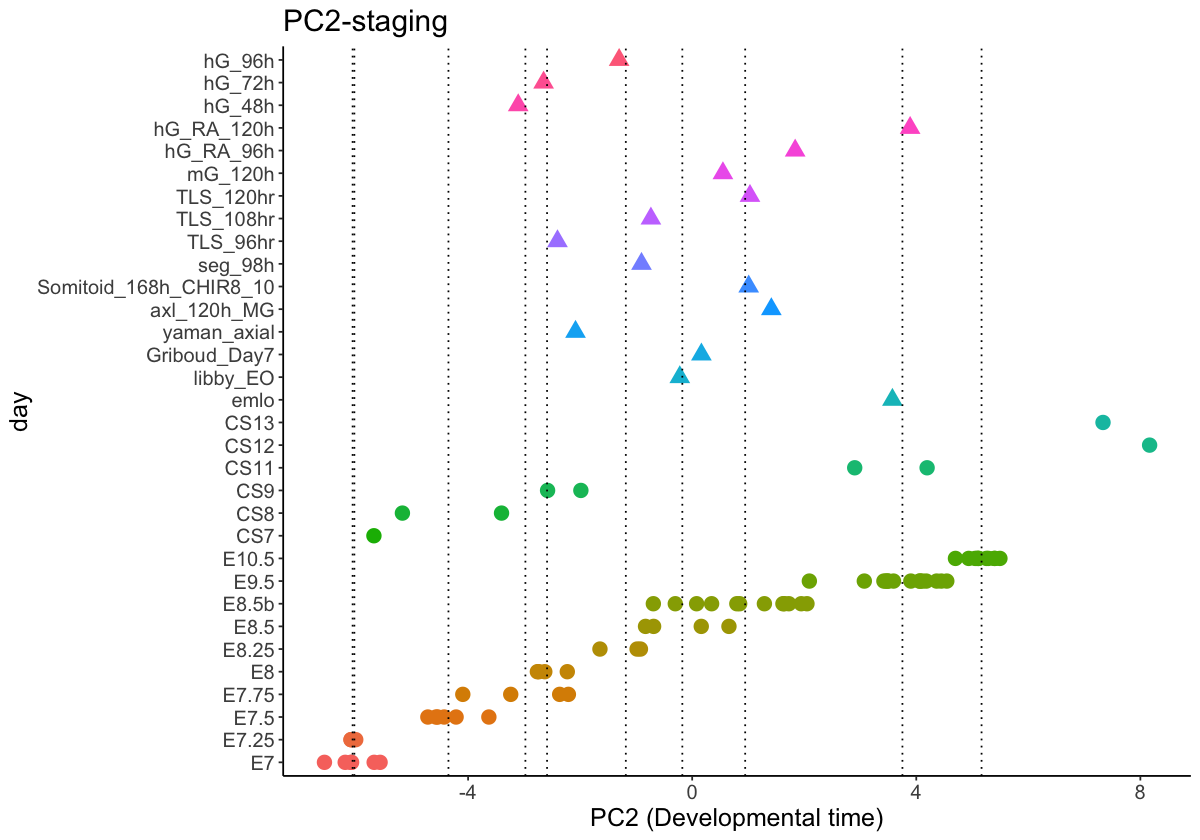

In [12]:
obj_heoa_cs7_hG_all$Source=ifelse(obj_heoa_cs7_hG_all$day %in% c('CS7',
                                                             'CS8','CS9','CS11',
                                                             'CS12','CS13',
                                             'E6.5','E6.75', 'E7','E7.25','E7.5','E7.75','E8','E8.25',
                                             'E8.5','E8.5b','E9.5','E10.5'), 'Embryo','Gastruloids')
df_pca2 <- obj_heoa_cs7_hG_all@meta.data
df_pca2$PCA_2 <- data.frame(Embeddings(obj_heoa_cs7_hG_all,reduction='pca'))$PCA_2
df_pca2$embryo_day <- ifelse(df_pca2$dataset %in% c('gastruloids','somitoids'),as.character(df_pca2$day),NA)
df_pca2$day <- factor(df_pca2$day, level=c(  'E6.5','E6.75',
                                             'E7','E7.25','E7.5','E7.75','E8','E8.25','E8.5',
                                             'E8.5b','E9.5','E10.5',
                                             'CS7','CS8','CS9','CS11','CS12','CS13',
                                             'emlo','libby_EO','Griboud_Day7','yaman_axial',
                                             'axl_120h_MG','Somitoid_168h_CHIR8_10','seg_98h',
                                             'TLS_96hr','TLS_108hr','TLS_120hr','mG_120h',
                                             'hG_RA_96h','hG_RA_120h',
                                             'hG_48h','hG_72h','hG_96h'
                                             ))
df_mean = df_pca2%>%group_by(day)%>%summarise(mean_PC2=mean(PCA_2))
df_mean = df_mean%>%head(10)
df_pca2 <- df_pca2[order(df_pca2$day),]%>%filter(!is.na(day))
options(repr.plot.width=10, repr.plot.height=7)
p1 <- ggplot(df_pca2,aes(x=PCA_2,y=day,color=day,shape=Source))+geom_point(size=4)+theme_classic()+
theme(text = element_text(size = 15))+ xlab('PC2 (Developmental time)')+
geom_vline(xintercept = df_mean$mean_PC2,linetype="dotted")+ggtitle('PC2-staging')+NoLegend()
p1